In [1]:
%matplotlib inline
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Loads datasets
player = pd.read_csv('data/baseball/player.csv')
salary = pd.read_csv('data/baseball/salary.csv')
appearances = pd.read_csv('data/baseball/appearances.csv')
batting = pd.read_csv('data/baseball/batting.csv')
team = pd.read_csv('data/baseball/team.csv')
pitching = pd.read_csv('data/baseball/pitching.csv')

### Scatterplots and Regressions

#### Do Higher Team Salaries Translate to More Wins?

In [3]:
team_salary = team.merge(salary).drop(1994)

In [4]:
# Creates variables for number of wins and total team salary by season 
def salary_year(year):
    team_salary_year = team_salary[team_salary.year == year]
    wins = team_salary_year.groupby('team_id')['w'].median()
    salary_total = team_salary_year.groupby('team_id')['salary'].sum()
    rel_salary_total = (salary_total - salary_total.mean()) / salary_total.std()
    return wins, rel_salary_total

In [5]:
# Creates scatterplot on variables from salary_year() functions
def wins_salary_graph(year):
    wins, salary_total = salary_year(year)
    plt.scatter(salary_total, wins)
    plt.ylabel("Team wins")
    plt.xlabel("Log total team salary")
    plt.title(f"How does salary impact wins?\n{year} season")

In [6]:
# Creates variables for number of wins and team salaries relative to the mean for that season
def salary_total():
    wins = team_salary.groupby(['year','team_id'])['w'].median().reset_index('year').drop('year',axis=1)
    salary_total = team_salary.groupby(['year','team_id'])['salary'].sum()
    rel_salary_total = (salary_total.xs(1985) - salary_total.xs(1985).mean()) / salary_total.xs(1985).std()
    for year in range(1986,2016):
        rel_salary = (salary_total.xs(year) - salary_total.xs(year).mean()) / salary_total.xs(year).std()
        rel_salary_total = pd.concat([rel_salary_total,rel_salary])
    return wins, rel_salary_total

In [7]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [8]:
# Produces regression for wins and team salaries all years
y, X = salary_total()
X = sm.add_constant(X)
results = smf.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      w   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     109.4
Date:                Mon, 20 Nov 2017   Prob (F-statistic):           3.19e-24
Time:                        19:41:13   Log-Likelihood:                -3405.6
No. Observations:                 888   AIC:                             6815.
Df Residuals:                     886   BIC:                             6825.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         79.9110      0.376    212.307      0.0

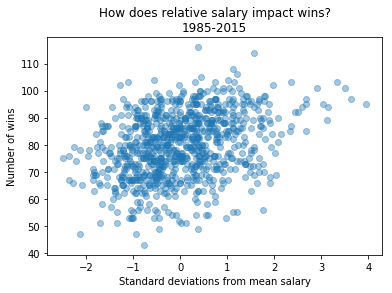

In [9]:
# Scatterplot 
wins, total_salary = salary_total()
plt.scatter(total_salary, wins, alpha=0.4)
plt.title('How does relative salary impact wins?\n1985-2015')
plt.xlabel('Standard deviations from mean salary')
plt.ylabel('Number of wins')

In [10]:
(team_salary[(team_salary.year == 2015)].groupby(['year', 'team_id'])['salary'].sum() / 1000000).describe()

count     30.000000
mean     116.975586
std       40.611048
min       56.959000
25%       90.591524
50%      112.683050
75%      121.657879
max      215.792000
Name: salary, dtype: float64

In [11]:
# Produces regressions for wins and log total team salary for each year, 1985-2015
for year in range(1985, 2016):
    y, X = salary_year(year)
    X = np.log(X)
    X = sm.add_constant(X)
    results = smf.OLS(y, X).fit()
    print(f'\nFor {year}:\n{results.summary()}')


For 1985:
                            OLS Regression Results                            
Dep. Variable:                      w   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 20 Nov 2017   Prob (F-statistic):                nan
Time:                        19:41:13   Log-Likelihood:                    nan
No. Observations:                  26   AIC:                               nan
Df Residuals:                      26   BIC:                               nan
Df Model:                          -1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const             nan        nan        n


For 2003:
                            OLS Regression Results                            
Dep. Variable:                      w   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 20 Nov 2017   Prob (F-statistic):                nan
Time:                        19:41:14   Log-Likelihood:                    nan
No. Observations:                  30   AIC:                               nan
Df Residuals:                      30   BIC:                               nan
Df Model:                          -1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const             nan        nan        n

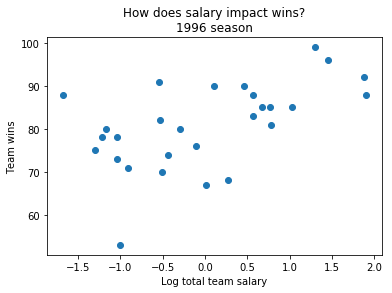

In [12]:
wins_salary_graph(1996)

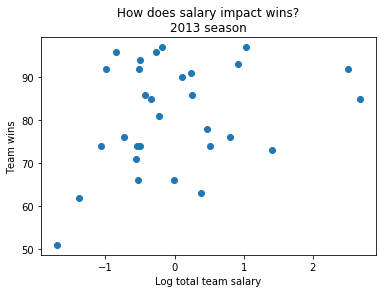

In [13]:
wins_salary_graph(2013)

#### Which statistics translate to higher salaries?

In [14]:
# Creates averages of important variables (same as the decision tree models)
batting = batting[(batting.year == 2015) & (batting.ab > 100)]
batting['avg'] = batting.h / batting.ab
batting['1b_avg'] = (batting.h - batting.double - batting.triple - batting.hr) / batting.ab
batting['2b_avg'] = batting.double / batting.ab
batting['3b_avg'] = batting.triple / batting.ab
batting['hr_avg'] = batting.hr / batting.ab
batting['r_avg'] = batting.r / batting.ab
batting['obp'] = ((batting.h + batting.bb + batting.hbp + batting.ibb) /
    (batting.ab + batting.bb + batting.hbp + batting.ibb))
batting['slug'] = (batting.h + batting.double + batting.triple * 2 + batting.hr * 3) / batting.ab
batting['bb_avg'] = (batting.bb + batting.ibb) / batting.ab
batting['hbp_avg'] = batting.hbp / batting.ab
batting_salary = salary.merge(batting)

In [15]:
# Adds player age as a potential indicator of salary
bat_player = batting_salary.merge(player)
bat_player['age'] = bat_player.year - bat_player.birth_year
batting_salary['age'] = bat_player.age

In [16]:
clean_batting = batting_salary[['salary','1b_avg','2b_avg','3b_avg','hr_avg','bb_avg','age']].dropna()
clean_batting.describe()

,salary,1b_avg,2b_avg,3b_avg,hr_avg,bb_avg,age
count,3.410000e+02,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000
mean,5.430086e+06,0.168802,0.050371,0.005626,0.029521,0.093709,29.501466
std,6.104767e+06,0.034728,0.013868,0.005730,0.017418,0.041910,3.753136
min,5.075000e+05,0.067961,0.007463,0.000000,0.000000,0.020455,21.000000
25%,5.340000e+05,0.144414,0.041190,0.000000,0.016892,0.064263,27.000000
50%,2.725000e+06,0.169643,0.050000,0.004184,0.027972,0.087719,29.000000
75%,8.000000e+06,0.193959,0.058577,0.008621,0.039877,0.114219,32.000000
max,2.500000e+07,0.274797,0.094421,0.032258,0.096774,0.289908,42.000000


In [17]:
y = clean_batting.pop('salary')
X = clean_batting

In [18]:
y = np.log(y)
X = sm.add_constant(X)
results = smf.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     53.44
Date:                Mon, 20 Nov 2017   Prob (F-statistic):           5.39e-46
Time:                        19:41:14   Log-Likelihood:                -457.77
No. Observations:                 341   AIC:                             929.5
Df Residuals:                     334   BIC:                             956.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3813      0.591     10.801      0.0